# Initializing Code

## Install Library

In [34]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries


In [35]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm
import yfinance as yf

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Defining Functions

In [36]:
# Maximum Drawdown Calculation
def drawdown(rets):
  """
  Takes a Stock Return from a DataFrame
  Computes:
  The Wealth Index
  The Previous Peaks
  Percent Drawdown
  Return:
  Percent Drawdown
  """

  wealth_index = 1000*(1+rets).cumprod()
  previous_peaks = wealth_index.cummax()
  drawdown = (wealth_index - previous_peaks)/previous_peaks
  return drawdown

In [37]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [38]:
# RSI Calculation

def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods).mean()
        ma_down = down.rolling(window = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Model 1: with MA(100) with a holding period of few days (Most successful until now)

## Execution

### Single Stock Data Analysis


In [54]:
# Manual Selected Pairs
'''

QQQ # NASDAQ 100
DIA # Dow Jones 30
SPY # SP500

'''

'\n\nQQQ # NASDAQ 100\nDIA # Dow Jones 30\nSPY # SP500\n\n'

Tckers to Change

In [55]:
# Tickers to Change ('CHD', 'MDLZ'), ('COST', 'EL'), ('DLTR', 'TSN'), ('HSY', 'MDLZ'), ('MDLZ', 'MKC')
# IMPORTANT ALWAYS PUT THE TICKERS BY ALPHABETICAL ORDER
tickers_list = ['GLD', 'GOLD']

In [56]:
# Parameters to Change
asset1 = tickers_list[0]
asset2 = tickers_list[1]

start = '2021-01-01'
end = None
interval = '1d'

# Fetch the data
data = yf.download(tickers_list, start = start, end = end, interval = interval)['Close'] # Year - Month - Day

[*********************100%***********************]  2 of 2 completed


In [57]:
data

,GLD,GOLD
Date,,
2021-01-04 00:00:00-05:00,182.330002,24.620001
2021-01-05 00:00:00-05:00,182.869995,24.280001
2021-01-06 00:00:00-05:00,179.899994,24.500000
2021-01-07 00:00:00-05:00,179.479996,24.770000
2021-01-08 00:00:00-05:00,173.339996,23.969999
...,...,...
2023-01-23 00:00:00-05:00,179.630005,19.230000
2023-01-24 00:00:00-05:00,180.279999,19.420000
2023-01-25 00:00:00-05:00,181.110001,19.790001


### Spread Analysis

In [58]:
# MA Parameters
ma_reversion_window = 100
stdv_window = 20
ma_entry_window = 20

In [59]:
# Spread Analysis
# Indexed Returns
data[f"{asset1} Indexed"] = (data[asset1].pct_change()+1).cumprod()
data[f"{asset2} Indexed"] = (data[asset2].pct_change()+1).cumprod()


# Spread Analysis and Computation
data['Ratio Spread'] = data[asset1] / data[asset2]
data['MA Reversion'] = data['Ratio Spread'].rolling(window= ma_reversion_window).mean()

data['Spread vs MA'] = data['Ratio Spread'] - data['MA Reversion']


data['z-score'] = zscore(data['Spread vs MA'])
data['s+1'] = +1
data['s-1'] = -1
data['s+2'] = +2
data['s-2'] = -2
data['s+3'] = +3
data['s-3'] = -3


data['MA Entry'] = data['z-score'].rolling(window= ma_entry_window).mean()

data

,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry
Date,,,,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,182.330002,24.620001,NaN,NaN,7.405767,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-05 00:00:00-05:00,182.869995,24.280001,1.002962,0.986190,7.531713,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-06 00:00:00-05:00,179.899994,24.500000,0.986672,0.995126,7.342857,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-07 00:00:00-05:00,179.479996,24.770000,0.984369,1.006093,7.245862,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-08 00:00:00-05:00,173.339996,23.969999,0.950694,0.973599,7.231539,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,179.630005,19.230000,0.985192,0.781072,9.341134,10.075927,-0.734792,-1.242966,1,-1,2,-2,3,-3,-1.257733
2023-01-24 00:00:00-05:00,180.279999,19.420000,0.988757,0.788790,9.283213,10.061681,-0.778468,-1.297770,1,-1,2,-2,3,-3,-1.269667
2023-01-25 00:00:00-05:00,181.110001,19.790001,0.993309,0.803818,9.151591,10.045944,-0.894353,-1.443181,1,-1,2,-2,3,-3,-1.288298


### Final Data Visualized

In [60]:
data = data

data.drop(index= data.index[0], 
        axis=0, 
        inplace=True)

In [61]:
data.dropna(inplace = True)
data

,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry
Date,,,,,,,,,,,,,,,
2021-06-23 00:00:00-04:00,166.139999,20.959999,0.911205,0.851340,7.926527,7.717759,0.208768,-0.058995,1,-1,2,-2,3,-3,-0.423101
2021-06-24 00:00:00-04:00,166.039993,20.969999,0.910656,0.851746,7.917978,7.719641,0.198337,-0.072083,1,-1,2,-2,3,-3,-0.382234
2021-06-25 00:00:00-04:00,166.589996,20.889999,0.913673,0.848497,7.974629,7.722346,0.252283,-0.004392,1,-1,2,-2,3,-3,-0.351822
2021-06-28 00:00:00-04:00,166.580002,20.700001,0.913618,0.840780,8.047343,7.725894,0.321448,0.082396,1,-1,2,-2,3,-3,-0.314624
2021-06-29 00:00:00-04:00,164.830002,20.530001,0.904020,0.833875,8.028738,7.729715,0.299023,0.054256,1,-1,2,-2,3,-3,-0.274150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,179.630005,19.230000,0.985192,0.781072,9.341134,10.075927,-0.734792,-1.242966,1,-1,2,-2,3,-3,-1.257733
2023-01-24 00:00:00-05:00,180.279999,19.420000,0.988757,0.788790,9.283213,10.061681,-0.778468,-1.297770,1,-1,2,-2,3,-3,-1.269667
2023-01-25 00:00:00-05:00,181.110001,19.790001,0.993309,0.803818,9.151591,10.045944,-0.894353,-1.443181,1,-1,2,-2,3,-3,-1.288298


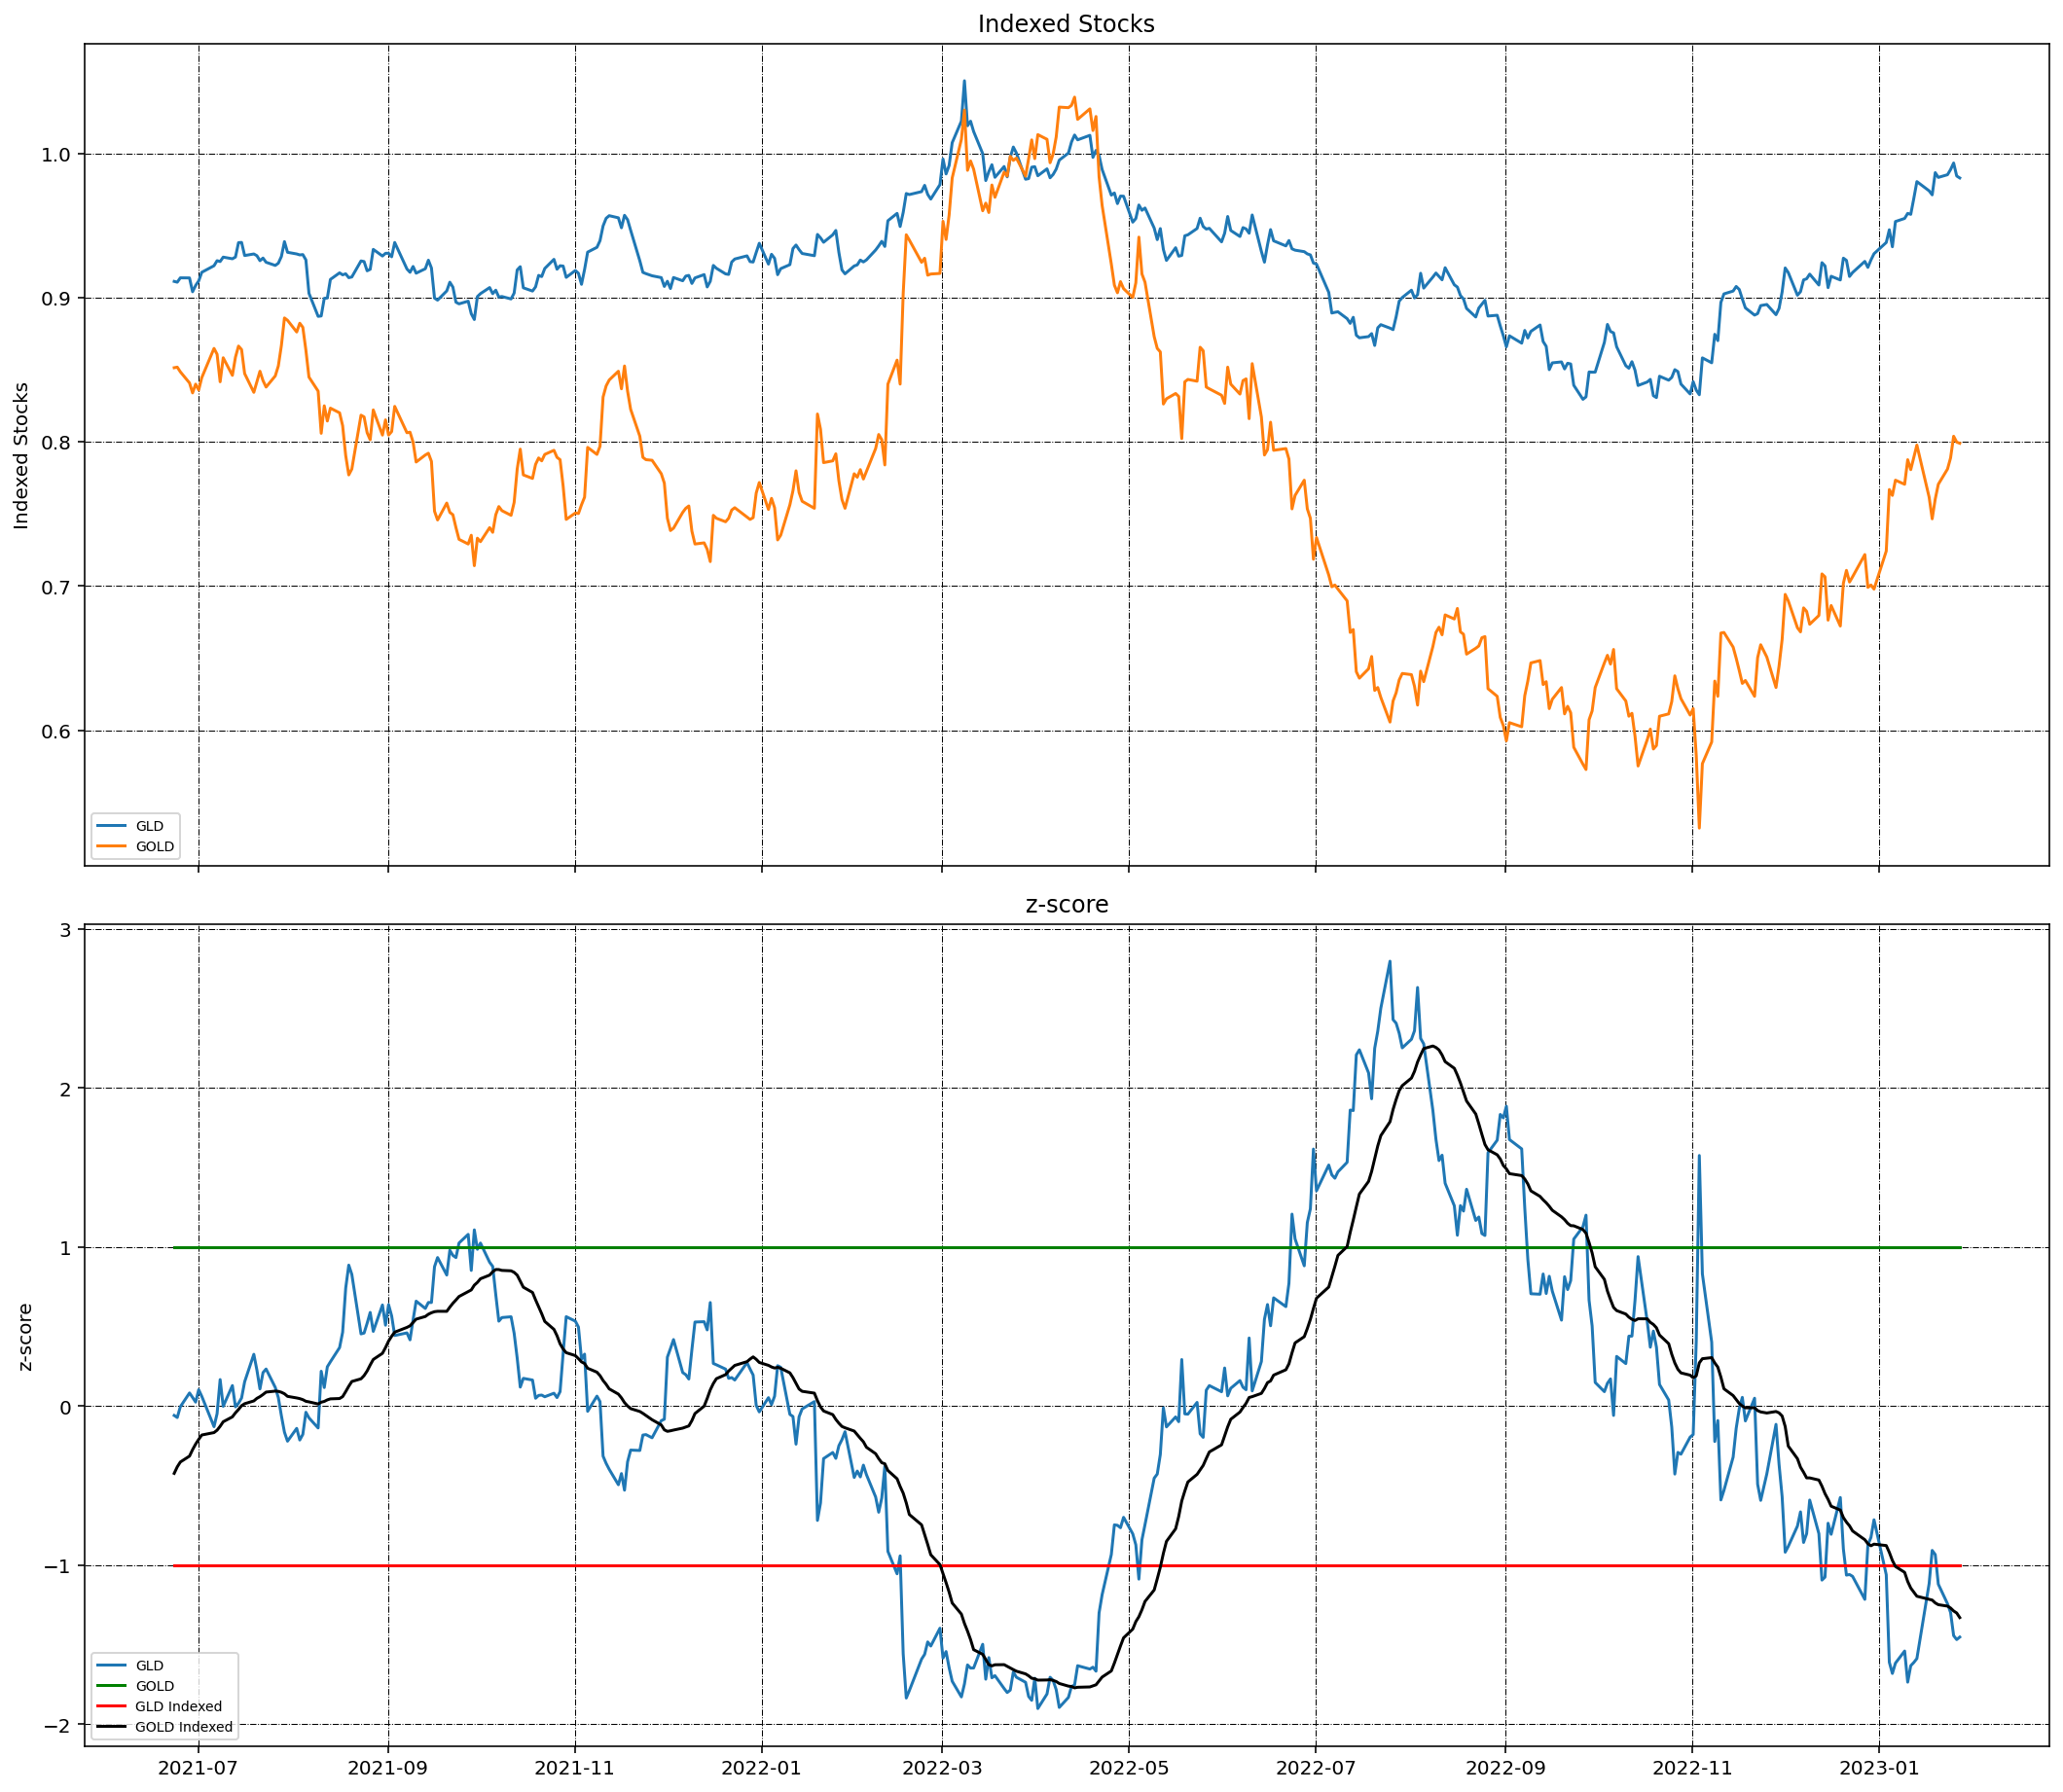

In [62]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(2, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)


# 1th graph
#Data
axs[0].plot(data[f"{asset1} Indexed"])
axs[0].plot(data[f"{asset2} Indexed"])
#Layout
axs[0].set_title('Indexed Stocks')
axs[0].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('Indexed Stocks')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


# 2rd graph
#Data
axs[1].plot(data['z-score'])
axs[1].plot(data['s+1'], label="s1", color="green")
axs[1].plot(data['s-1'], label="s-1", color="red")
#axs[2].plot(data['s+2'], label="s2", color="green")
#axs[2].plot(data['s-2'], label="s-2", color="red")
#axs[2].plot(data['s+3'], label="s3", color="green")
#axs[2].plot(data['s-3'], label="s-3", color="red")
axs[1].plot(data['MA Entry'], label="MA Entry", color="black")
#Layout
axs[1].set_title('z-score')
axs[1].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[1].set_ylabel('z-score')
axs[1].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


#### Trial for the new formula

In [63]:
'''
SL1 = 0.2 # 20%
TP1 = 0.8 # 60%
SL2 = 0.2 # 10%
TP2 = 0.8 # 60%
Stop_Loss_lvl = Position Taken - 20% 
Take_Profit_lvl

'''

'\nSL1 = 0.2 # 20%\nTP1 = 0.8 # 60%\nSL2 = 0.2 # 10%\nTP2 = 0.8 # 60%\nStop_Loss_lvl = Position Taken - 20% \nTake_Profit_lvl\n\n'

In [1]:
# Add a Dynamic condition for the SL and TP
SL = 0.4 # 40%
TP = 0.8 # 80%

# when I open the Position, I want to put a Stop Loss that will be 40% away from the buy_signal generated or if the Spread <= MA entry, execute stop loss


In [65]:
# Stop Loss and Take Profit
#this one u need to modify to only take the percentages he asked for
#Works 1 excel conditional formating (coloring the data)
#create a function to signal when to buy and sell the stock (NEW CODE)
#this is the dynamic version
def buy_sell(data):
  #Create Empty lists
  Buy_signal1 = [] 
  Sell_signal1 = [] 
  Stop_Loss_lvl = []
  Take_Profit_lvl = []
  Stop_Loss_lvl_dyn = []
  Take_Profit_lvl_dyn = []

  #flag = -1 #when the Spread hit a threshold

  for i in range(len(data)): #for each itteration, until the data is finished (lendata)
    if data['z-score'][i] <= data['s-1'][i]:
      if data['z-score'][i] >= data['MA Entry'][i]:   #BUY 1
        Buy_signal1.append(data['z-score'][i])
        Sell_signal1.append(np.nan)

        Stop_Loss_lvl.append(data['z-score'][i] + data['z-score'][i]* SL) #SL
        if data['z-score'][i] < data['MA Entry'][i]:
          Stop_Loss_lvl_dyn.append(data['z-score'][i]) #SL Dynamic


        Take_Profit_lvl.append(data['z-score'][i] - data['z-score'][i]* TP) #TP
        if data['z-score'][i] > data['MA Entry'][i]:
          Take_Profit_lvl_dyn.append(data['z-score'][i]) #SL Dynamic
    
    
    
    elif data['z-score'][i] >= data['s-1'][i]:
      if data['z-score'][i] <= data['MA Entry'][i]: #Sell 1
        Buy_signal1.append(np.nan)
        Sell_signal1.append(data['z-score'][i])

        Stop_Loss_lvl.append(data['z-score'][i] + data['z-score'][i]* SL) #SL
        if data['z-score'][i] > data['MA Entry'][i]:
          Stop_Loss_lvl_dyn.append(data['z-score'][i]) #SL Dynamic
        
        Take_Profit_lvl.append(data['z-score'][i] - data['z-score'][i]* TP) #TP
        if data['z-score'][i] > data['MA Entry'][i]:
          Take_Profit_lvl_dyn.append(data['z-score'][i]) #SL Dynamic
        


### SL and TP (1st Code ok, Have to Adjust the Syntax)

In [66]:
#modify
# mentions that you have to remove 
#no more percentages, just upper and lower limit
SL1 = 0.2 # 20%
TP1 = 0.8 # 60%
#SL2 = 0.2 # 10% #remove 
#TP2 = 0.8 # 60% #remove

In [67]:
data

,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry
Date,,,,,,,,,,,,,,,
2021-06-23 00:00:00-04:00,166.139999,20.959999,0.911205,0.851340,7.926527,7.717759,0.208768,-0.058995,1,-1,2,-2,3,-3,-0.423101
2021-06-24 00:00:00-04:00,166.039993,20.969999,0.910656,0.851746,7.917978,7.719641,0.198337,-0.072083,1,-1,2,-2,3,-3,-0.382234
2021-06-25 00:00:00-04:00,166.589996,20.889999,0.913673,0.848497,7.974629,7.722346,0.252283,-0.004392,1,-1,2,-2,3,-3,-0.351822
2021-06-28 00:00:00-04:00,166.580002,20.700001,0.913618,0.840780,8.047343,7.725894,0.321448,0.082396,1,-1,2,-2,3,-3,-0.314624
2021-06-29 00:00:00-04:00,164.830002,20.530001,0.904020,0.833875,8.028738,7.729715,0.299023,0.054256,1,-1,2,-2,3,-3,-0.274150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,179.630005,19.230000,0.985192,0.781072,9.341134,10.075927,-0.734792,-1.242966,1,-1,2,-2,3,-3,-1.257733
2023-01-24 00:00:00-05:00,180.279999,19.420000,0.988757,0.788790,9.283213,10.061681,-0.778468,-1.297770,1,-1,2,-2,3,-3,-1.269667
2023-01-25 00:00:00-05:00,181.110001,19.790001,0.993309,0.803818,9.151591,10.045944,-0.894353,-1.443181,1,-1,2,-2,3,-3,-1.288298


In [68]:
#create a function to signal when to buy and sell the stock
#static strategy
def buy_sell(data):
  #Create Empty lists
  Buy_signal = [] 
  Sell_signal = [] 
  Stop_Loss_lvl = []
  Take_Profit_lvl = []

  for i in range(len(data)): #for each iteration, until the data is finished
    if data['z-score'][i] <= data['s-1'][i]: #BUY
      Buy_signal.append(data['z-score'][i])
      Sell_signal.append(np.nan)
      Stop_Loss_lvl.append(data['z-score'][i] + data['z-score'][i]* SL1) #SL
      Take_Profit_lvl.append(data['z-score'][i] - data['z-score'][i]* TP1) #TP
    elif data['z-score'][i] >= data['s+1'][i]: #SELL
      Buy_signal.append(np.nan)
      Sell_signal.append(data['z-score'][i])
      Stop_Loss_lvl.append(data['z-score'][i] + data['z-score'][i]* SL1) #SL
      Take_Profit_lvl.append(data['z-score'][i] - data['z-score'][i]* TP1) #TP
    else: # off range +17 , off range [5,-5], off range -17
      Buy_signal.append(np.nan)
      Sell_signal.append(np.nan)
      Stop_Loss_lvl.append(np.nan)
      Take_Profit_lvl.append(np.nan)
  return (Buy_signal, Sell_signal, Stop_Loss_lvl, Take_Profit_lvl)

In [69]:
#store the buy and sell data into a variable (NEW CODE)
buy_sell = buy_sell(data) #create a variable
data['Buy_signal1'] = buy_sell[0]
data['Sell_signal1'] = buy_sell[2]
data['Stop_Loss_lvl'] = buy_sell[4]
data['Take_Profit_lvl'] = buy_sell[5]

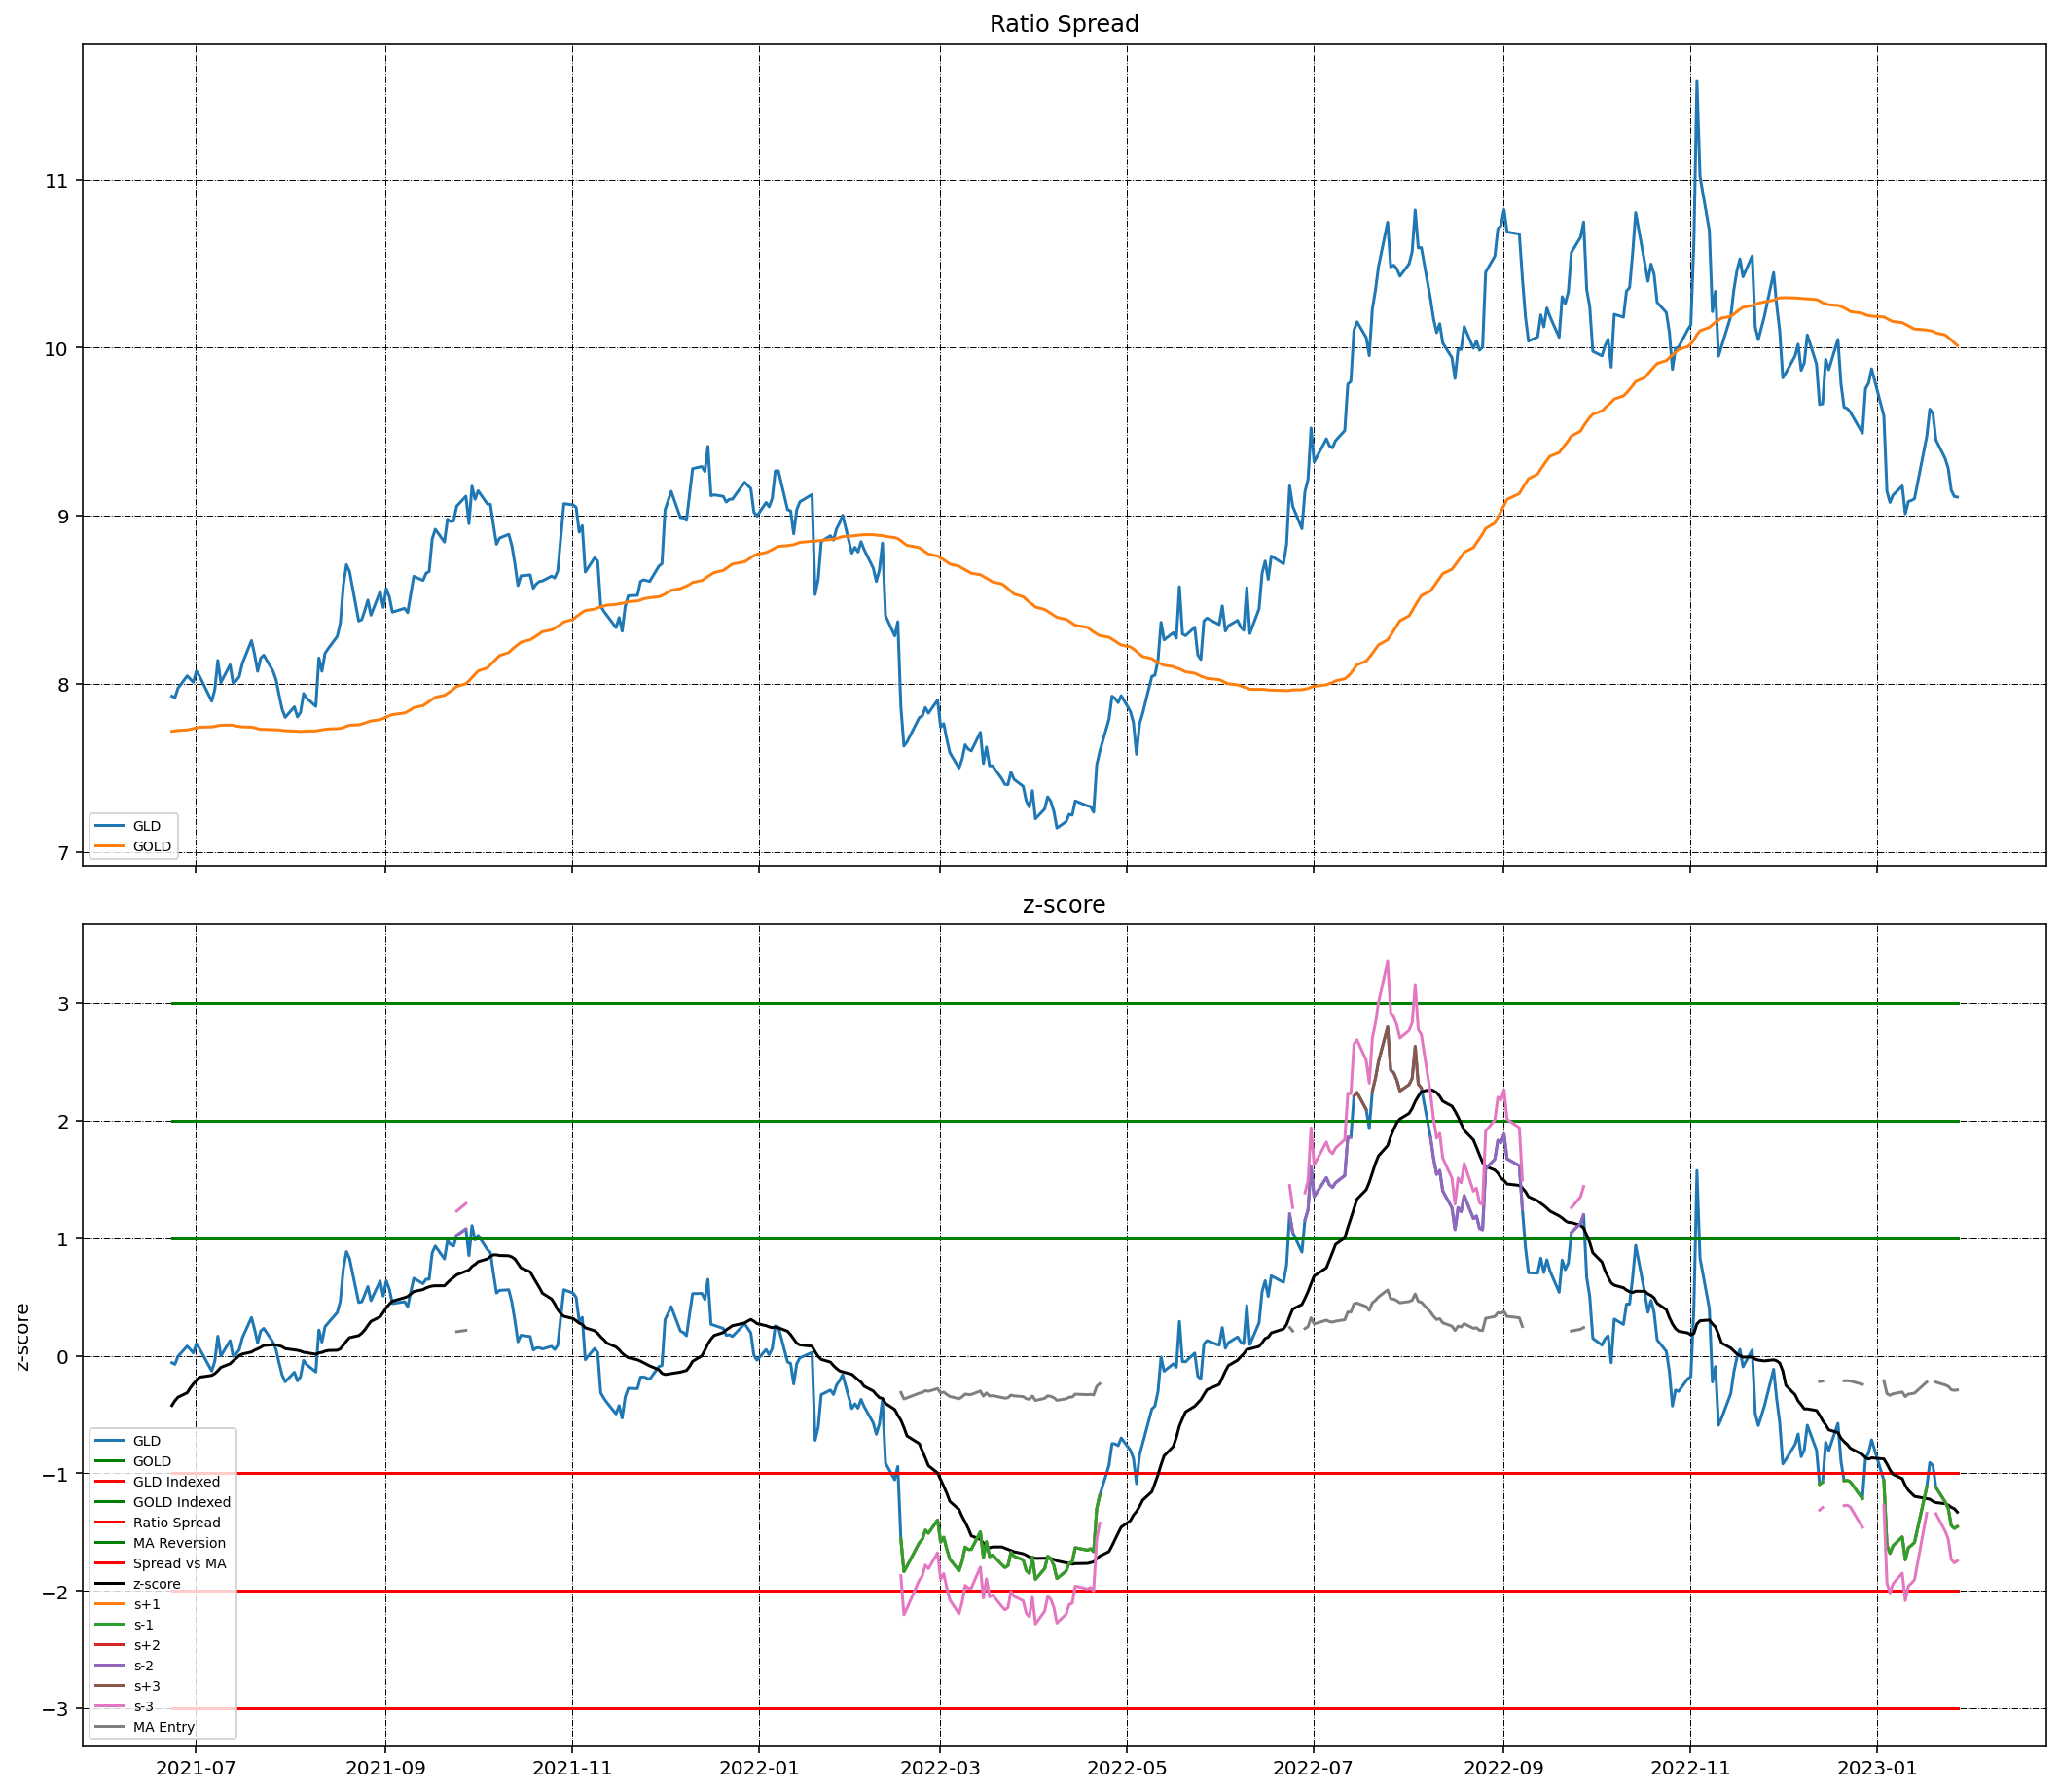

In [74]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(2, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)

# 1st graph
#Data
axs[0].plot(data['Ratio Spread'])
axs[0].plot(data['MA Reversion'])
#Layout
axs[0].set_title('Ratio Spread') # change to spread of the tickers
axs[0].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)



# 3rd graph
#Data
axs[1].plot(data['z-score'])
axs[1].plot(data['s+1'], label="s1", color="green")
axs[1].plot(data['s-1'], label="s-1", color="red")
axs[1].plot(data['s+2'], label="s2", color="green")
axs[1].plot(data['s-2'], label="s-2", color="red")
axs[1].plot(data['s+3'], label="s3", color="green")
axs[1].plot(data['s-3'], label="s-3", color="red")
axs[1].plot(data['MA Entry'], label="MA Entry", color="black")

axs[1].plot(data['Buy_signal1'])
axs[1].plot(data['Buy_signal1'])
axs[1].plot(data['Sell_signal1'])
axs[1].plot(data['Stop_Loss_lvl'])
axs[1].plot(data['Take_Profit_lvl'])

#Layout
axs[1].set_title('z-score')
axs[1].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[1].set_ylabel('z-score')
axs[1].grid(which="major", color='k', linestyle='-.', linewidth=0.5)

In [75]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 403 entries, 2021-06-23 00:00:00-04:00 to 2023-01-27 00:00:00-05:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GLD              403 non-null    float64
 1   GOLD             403 non-null    float64
 2   GLD Indexed      403 non-null    float64
 3   GOLD Indexed     403 non-null    float64
 4   Ratio Spread     403 non-null    float64
 5   MA Reversion     403 non-null    float64
 6   Spread vs MA     403 non-null    float64
 7   z-score          403 non-null    float64
 8   s+1              403 non-null    int64  
 9   s-1              403 non-null    int64  
 10  s+2              403 non-null    int64  
 11  s-2              403 non-null    int64  
 12  s+3              403 non-null    int64  
 13  s-3              403 non-null    int64  
 14  MA Entry         403 non-null    float64
 15  Buy_signal1      70 non-null     float64
 16  Buy_signal2  

In [76]:
data_2 = pd.DataFrame(data, columns = ['z-score','Buy_signal1', 'Sell_signal1', 'Stop_Loss_lvl', 'Take_Profit_lvl', 'PandL', 'CumPandL'])

In [77]:
data_2

,z-score,Buy_signal1,Buy_signal2,Sell_signal1,Sell_signal2,Stop_Loss_lvl,Take_Profit_lvl,PandL,CumPandL
Date,,,,,,,,,
2021-06-23 00:00:00-04:00,-0.058995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-24 00:00:00-04:00,-0.072083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-25 00:00:00-04:00,-0.004392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-28 00:00:00-04:00,0.082396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-29 00:00:00-04:00,0.054256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,-1.242966,-1.242966,NaN,NaN,NaN,-1.491560,-0.248593,NaN,NaN
2023-01-24 00:00:00-05:00,-1.297770,-1.297770,NaN,NaN,NaN,-1.557324,-0.259554,NaN,NaN
2023-01-25 00:00:00-05:00,-1.443181,-1.443181,NaN,NaN,NaN,-1.731818,-0.288636,NaN,NaN


In [78]:

#Initialize the Variables needed
#Position size that can be traded
position_size_per_spread_signal1 = 100


#Position size that can be traded
Maximum_Position_Size = 2
Actual_Position_Size = 0
Entry_Long = 0
Entry_Short = 0

#Fixing initial Values of different thrseholds (if we have more room to enter more positions, we double the work done later)
stop_loss_value_pos1 = 0     # SL of the FIRST position opened
stop_loss_value_pos2 = 0     # SL of the SECOND position opened
take_profit_value_pos1 = 0   # TP of the FIRST position opened
take_profit_value_pos2 = 0   # TP of the SECOND position opened

#initial spread size (at position i)
buy_place_pos1 = 0
buy_place_pos2 = 0

position_size_per_spread_pos1 = 0
position_size_per_spread_pos2 = 0

#create empty lists used in Plotting graphs, where x and y are the coordinates of the data
entry_long_x = []
entry_long_y = []

entry_short_x = []
entry_short_y = []

stop_loss_x = []
stop_loss_y = []

In [79]:
import pandas as pd

# Loop through each data point
for i in range(len(data_2)):
    
    # Check if Actual Position Size is lower than Maximum Position Size to execute the order (position 1)
    if stop_loss_value_pos1 != 0 and take_profit_value_pos1 != 0 and buy_place_pos1 != 0 and position_size_per_spread_pos1 != 0:
        
        # Positive Side (Short Selling) Closing position 1 opened
        if data_2['z-score'][i] >= 0:
            
            # Loss calculation, SL hit
            if data_2['z-score'][i] > stop_loss_value_pos1:
                data_2['PandL'][buy_place_pos1] = (data_2['z-score'][buy_place_pos1] - stop_loss_value_pos1) * position_size_per_spread_pos1 
                Actual_Position_Size = 1
                stop_loss_value_pos1 = 0
                take_profit_value_pos1 = 0
                buy_place_pos1 = 0
                position_size_per_spread_pos1 = 0

                stop_loss_x.append(i)
                stop_loss_y.append(data_2['z-score'][i])

            # Profit calculation, TP hit
            elif data_2['z-score'][i] < take_profit_value_pos1:
                data_2['PandL'][buy_place_pos1] = (-data_2['z-score'][i] + data_2['z-score'][buy_place_pos1]) * position_size_per_spread_pos1 
                Actual_Position_Size = 1
                stop_loss_value_pos1 = 0
                take_profit_value_pos1 = 0
                buy_place_pos1 = 0
                position_size_per_spread_pos1 = 0

                entry_long_x.append(i)
                entry_long_y.append(data_2['z-score'][i])
                entry_short_x.append(buy_place_pos1)
                entry_short_y.append(data_2['z-score'][buy_place_pos1])
        
        # Negative Side (Long Buying) Closing position 1 opened
        else:
            
            # Loss calculation, SL hit
            if data_2['z-score'][i] < stop_loss_value_pos1:
                data_2['PandL'][buy_place_pos1] = (-data_2['z-score'][buy_place_pos1] + stop_loss_value_pos1) * position_size_per_spread_pos1 
                Actual_Position_Size -= 1
                stop_loss_value_pos1 = 0
                take_profit_value_pos1 = 0
                buy_place_pos1 = 0
                position_size_per_spread_pos1 = 0

                stop_loss_x.append(i)
                stop_loss_y.append(data_2['z-score'][i])
            
            # Profit calculation, TL hit
            elif data_2['z-score'][i] > take_profit_value_pos1:
                data_2['PandL'][buy_place_pos1] = (data_2['z-score'][i] - data_2['z-score'][buy_place_pos1]) * position_size_per_spread_pos1 
                Actual_Position_Size = 1
                stop_loss_value_pos1 = 0
                take_profit_value_pos1 = 0
                buy_place_pos1 = 0
                position_size_per_spread_pos1 = 0

                entry_long_x.append(buy_place_pos1)
                entry_long_y.append(data_2['z-score'][buy_place_pos1])
                entry_short_x.append(i)
                entry_short_y.append(data_2['z-score'][i])


In [80]:
data = data.reset_index()
data

,Date,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,...,s-2,s+3,s-3,MA Entry,Buy_signal1,Buy_signal2,Sell_signal1,Sell_signal2,Stop_Loss_lvl,Take_Profit_lvl
0,2021-06-23 00:00:00-04:00,166.139999,20.959999,0.911205,0.851340,7.926527,7.717759,0.208768,-0.058995,1,...,-2,3,-3,-0.423101,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-24 00:00:00-04:00,166.039993,20.969999,0.910656,0.851746,7.917978,7.719641,0.198337,-0.072083,1,...,-2,3,-3,-0.382234,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-25 00:00:00-04:00,166.589996,20.889999,0.913673,0.848497,7.974629,7.722346,0.252283,-0.004392,1,...,-2,3,-3,-0.351822,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-28 00:00:00-04:00,166.580002,20.700001,0.913618,0.840780,8.047343,7.725894,0.321448,0.082396,1,...,-2,3,-3,-0.314624,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-29 00:00:00-04:00,164.830002,20.530001,0.904020,0.833875,8.028738,7.729715,0.299023,0.054256,1,...,-2,3,-3,-0.274150,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2023-01-23 00:00:00-05:00,179.630005,19.230000,0.985192,0.781072,9.341134,10.075927,-0.734792,-1.242966,1,...,-2,3,-3,-1.257733,-1.242966,NaN,NaN,NaN,-1.491560,-0.248593
399,2023-01-24 00:00:00-05:00,180.279999,19.420000,0.988757,0.788790,9.283213,10.061681,-0.778468,-1.297770,1,...,-2,3,-3,-1.269667,-1.297770,NaN,NaN,NaN,-1.557324,-0.259554
400,2023-01-25 00:00:00-05:00,181.110001,19.790001,0.993309,0.803818,9.151591,10.045944,-0.894353,-1.443181,1,...,-2,3,-3,-1.288298,-1.443181,NaN,NaN,NaN,-1.731818,-0.288636
401,2023-01-26 00:00:00-05:00,179.470001,19.690001,0.984314,0.799756,9.114779,10.028888,-0.914109,-1.467971,1,...,-2,3,-3,-1.300935,-1.467971,NaN,NaN,NaN,-1.761565,-0.293594


In [81]:
#Simple calculations
account_amount = 100000 #100,000$
Short_position_margin = 1.5 #150%
Maximum_short_position_size = account_amount / Short_position_margin #66,666$
#Maximum_spread_size = Maximum_short_position_size / df['PEP'].max() #Max spread size based on the short margin limitation
#Position_size_per_pread = Maximum_spread_size / 2 #Safe Position sizing to protect the short margin 
#Position_actual_size = Position_size_per_pread / Maximum_spread_size # used later to backtest correctly the actual size
#transform to input (Optional)
print('Account Amount ' + str(account_amount))
print('Short Position Margin in % ' + str(Short_position_margin * 100))
print('Maximum Short Position Size ' + str(Maximum_short_position_size))
#print('Maximum Spread Size ' + str(Maximum_spread_size))
#print('Position Size per Spread ' + str(Position_size_per_pread))
#print('Position Actual Size ' + str(Position_actual_size))

Account Amount 100000
Short Position Margin in % 150.0
Maximum Short Position Size 66666.66666666667


In [82]:
current_balance = account_amount

for i in range(len(data_2)):

  if not np.isnan(data_2['PandL'][i]):

    current_balance += data_2['PandL'][i]

    data_2['CumPandL'][i] = current_balance

  else:

    data_2['CumPandL'][i] = current_balance

data_2.to_csv('newdata2.csv')

In [83]:
number_of_years = 4


#Total number of profitable trades 
#Total value of profitable trades
#Total number of losing trades
#Total value of losing trades
#Maximum loss (drawdown) 


Total_Strategy_PandL_in_USD = data_2['PandL'].sum()
Annualized_Strategy_PandL_in_USD = data_2['PandL'].sum() / number_of_years 
Strategy_ROI = (data_2['PandL'].sum() / account_amount) * 100
Annualized_Strategy_ROI = (Annualized_Strategy_PandL_in_USD / account_amount) * 100
Total_number_of_profitable_trades = data_2['PandL'].gt(0).sum() #double check
Total_number_of_losing_trades = data_2['PandL'].lt(0).sum() #double check


print('Total strategy P&L in $ value: ' + str(round(Total_Strategy_PandL_in_USD, 2)) + ' $')
print('Annualized Strategy P&L in $ value: ' + str(round(Annualized_Strategy_PandL_in_USD, 2)) + ' $')
print('Total Strategy P&L in % (Return on Investment): ' + str(round(Strategy_ROI, 2)) + ' %')
print('Annualized Strategy P&L in % (Return on Investment): ' + str(round(Annualized_Strategy_ROI, 2)) + ' %')
print('Total number of profitable trades: ' + str(Total_number_of_profitable_trades))
print('Total number of losing trades: ' + str(Total_number_of_losing_trades))

Total strategy P&L in $ value: 700.43 $
Annualized Strategy P&L in $ value: 175.11 $
Total Strategy P&L in % (Return on Investment): 0.7 %
Annualized Strategy P&L in % (Return on Investment): 0.18 %
Total number of profitable trades: 6
Total number of losing trades: 6


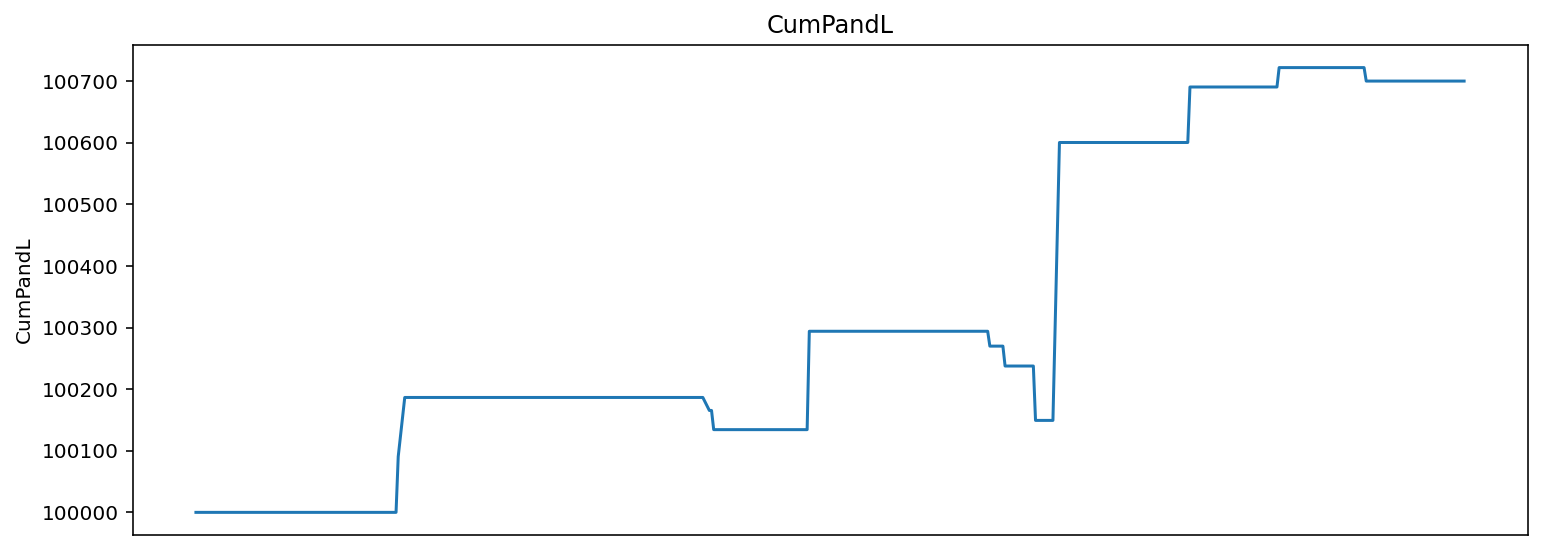

In [84]:
#Visualize the Data (NEW CODE)
plt.figure(figsize=(12.5, 4.5))

plt.plot(data_2['CumPandL'])

plt.title('CumPandL')
plt.xlabel('')
plt.ylabel('CumPandL')
plt.xticks([]) # remove dates which will cause noise
plt.show()

In [85]:
data_2 = data_2.reset_index()

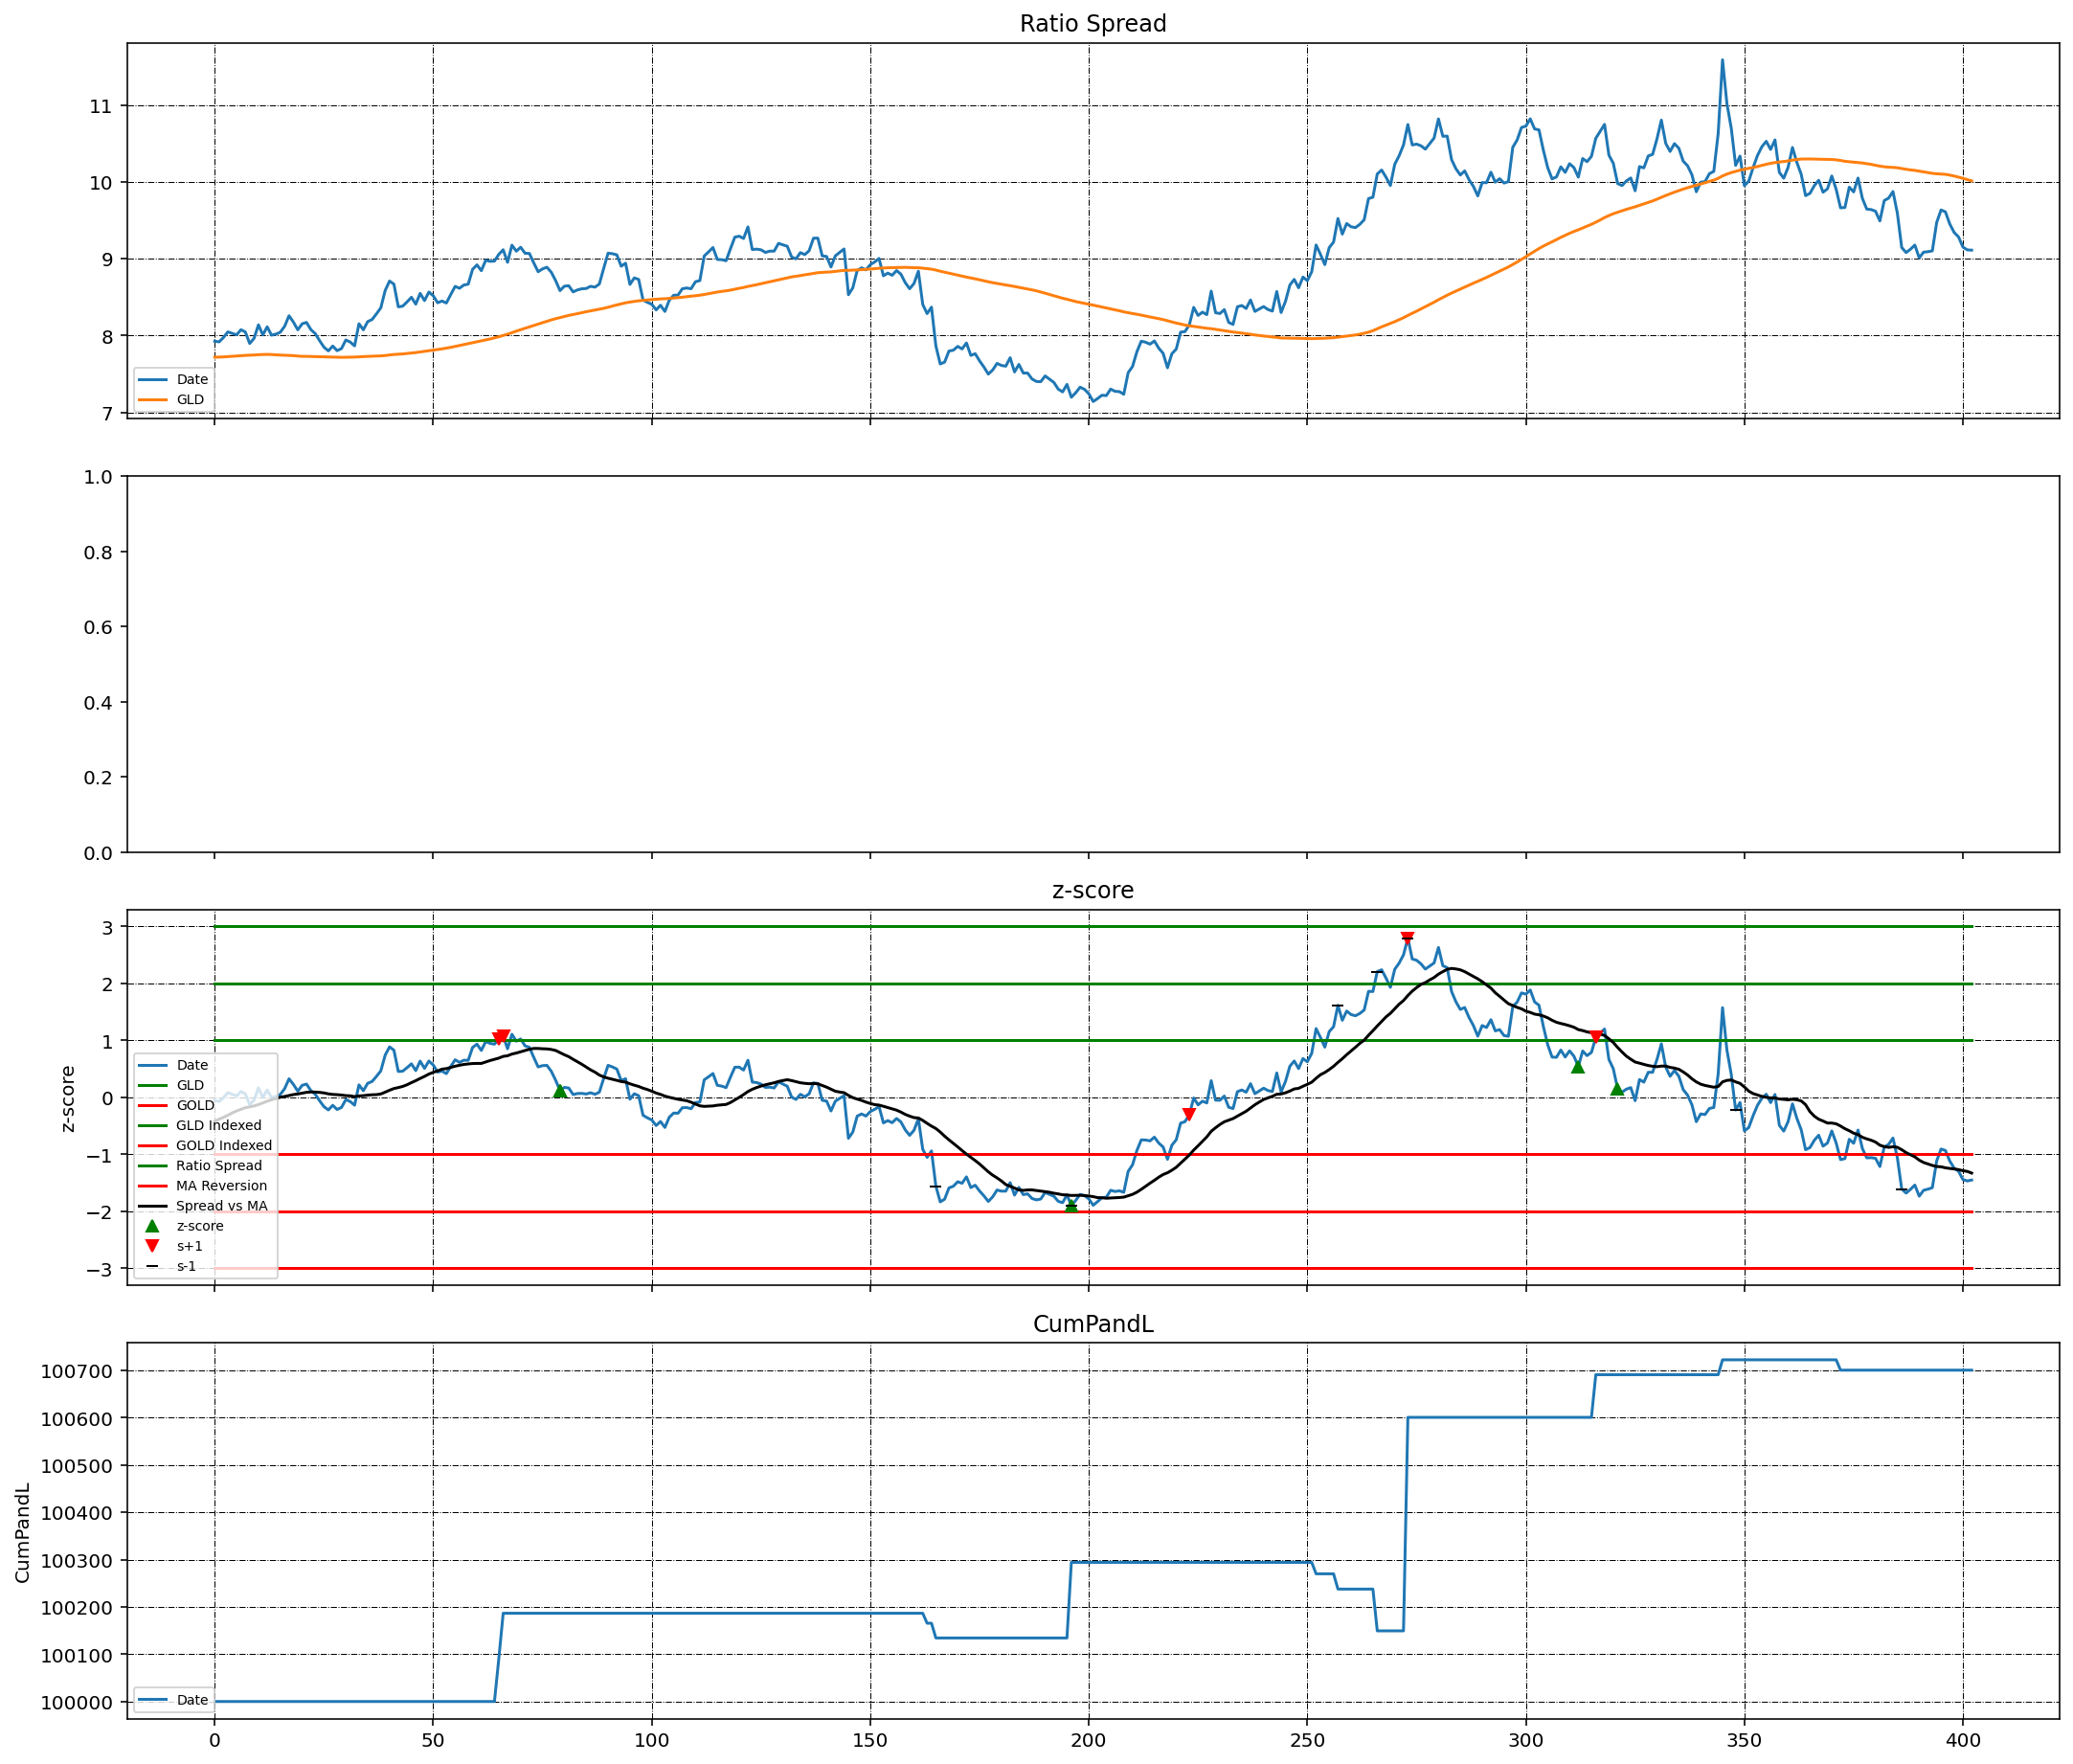

In [88]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(4, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)

# 1st graph
#Data
axs[0].plot(data['Ratio Spread'])
axs[0].plot(data['MA Reversion'])
#Layout
axs[0].set_title('Ratio Spread') # change to spread of the tickers
axs[0].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)



# 3rd graph
#Data
axs[2].plot(data['z-score'])
axs[2].plot(data['s+1'], label="s1", color="green")
axs[2].plot(data['s-1'], label="s-1", color="red")
axs[2].plot(data['s+2'], label="s2", color="green")
axs[2].plot(data['s-2'], label="s-2", color="red")
axs[2].plot(data['s+3'], label="s3", color="green")
axs[2].plot(data['s-3'], label="s-3", color="red")
axs[2].plot(data['MA Entry'], label="MA Entry", color="black")

axs[2].plot(entry_long_x, entry_long_y, 'g^', label = 'Buy/Cover order' ) #green arrows
axs[2].plot(entry_short_x, entry_short_y, 'rv', label = 'Sell/Short order') #red arrows
axs[2].plot(stop_loss_x, stop_loss_y, 'k_', label = 'Stop Loss') #black bars

#Layout
axs[2].set_title('z-score')
axs[2].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[2].set_ylabel('z-score')
axs[2].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


# 4th graph
#Data
axs[3].plot(data_2['CumPandL'])
#Layout
axs[3].set_title('CumPandL')
axs[3].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[3].set_ylabel('CumPandL')
axs[3].grid(which="major", color='k', linestyle='-.', linewidth=0.5)

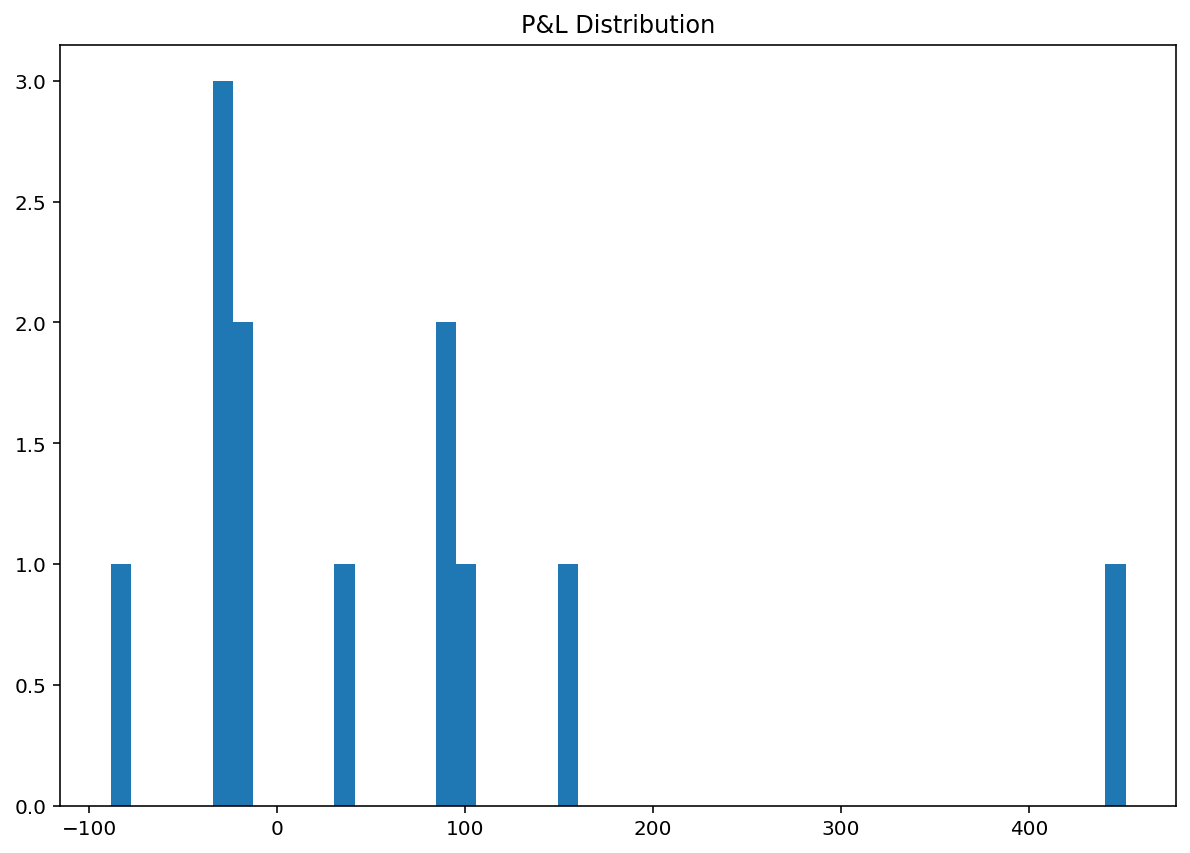

In [89]:
plt.figure(figsize=(10, 7))
plt.hist(data_2['PandL'], bins = 50)
plt.title('P&L Distribution')
plt.xlabel('')
plt.plot(label = 'Distribution')
plt.show()

#### Zoomed View

In [90]:
zoom_data = data[-200:]
zoom_data

,Date,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,...,s-2,s+3,s-3,MA Entry,Buy_signal1,Buy_signal2,Sell_signal1,Sell_signal2,Stop_Loss_lvl,Take_Profit_lvl
203,2022-04-12 00:00:00-04:00,183.770004,25.440001,1.007898,1.033306,7.223664,8.372861,-1.149197,-1.762958,1,...,-2,3,-3,-1.763060,-1.762958,NaN,NaN,NaN,-2.115549,-0.352592
204,2022-04-13 00:00:00-04:00,184.649994,25.580000,1.012724,1.038993,7.218530,8.360445,-1.141915,-1.753820,1,...,-2,3,-3,-1.771686,-1.753820,NaN,NaN,NaN,-2.104584,-0.350764
205,2022-04-14 00:00:00-04:00,184.039993,25.200001,1.009379,1.023558,7.303174,8.348237,-1.045063,-1.632291,1,...,-2,3,-3,-1.767881,-1.632291,NaN,NaN,NaN,-1.958749,-0.326458
206,2022-04-18 00:00:00-04:00,184.610001,25.379999,1.012505,1.030869,7.273838,8.335710,-1.061872,-1.653383,1,...,-2,3,-3,-1.765807,-1.653383,NaN,NaN,NaN,-1.984060,-0.330677
207,2022-04-19 00:00:00-04:00,181.820007,25.010000,0.997203,1.015841,7.269892,8.322315,-1.052423,-1.641527,1,...,-2,3,-3,-1.759088,-1.641527,NaN,NaN,NaN,-1.969832,-0.328305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2023-01-23 00:00:00-05:00,179.630005,19.230000,0.985192,0.781072,9.341134,10.075927,-0.734792,-1.242966,1,...,-2,3,-3,-1.257733,-1.242966,NaN,NaN,NaN,-1.491560,-0.248593
399,2023-01-24 00:00:00-05:00,180.279999,19.420000,0.988757,0.788790,9.283213,10.061681,-0.778468,-1.297770,1,...,-2,3,-3,-1.269667,-1.297770,NaN,NaN,NaN,-1.557324,-0.259554
400,2023-01-25 00:00:00-05:00,181.110001,19.790001,0.993309,0.803818,9.151591,10.045944,-0.894353,-1.443181,1,...,-2,3,-3,-1.288298,-1.443181,NaN,NaN,NaN,-1.731818,-0.288636
401,2023-01-26 00:00:00-05:00,179.470001,19.690001,0.984314,0.799756,9.114779,10.028888,-0.914109,-1.467971,1,...,-2,3,-3,-1.300935,-1.467971,NaN,NaN,NaN,-1.761565,-0.293594


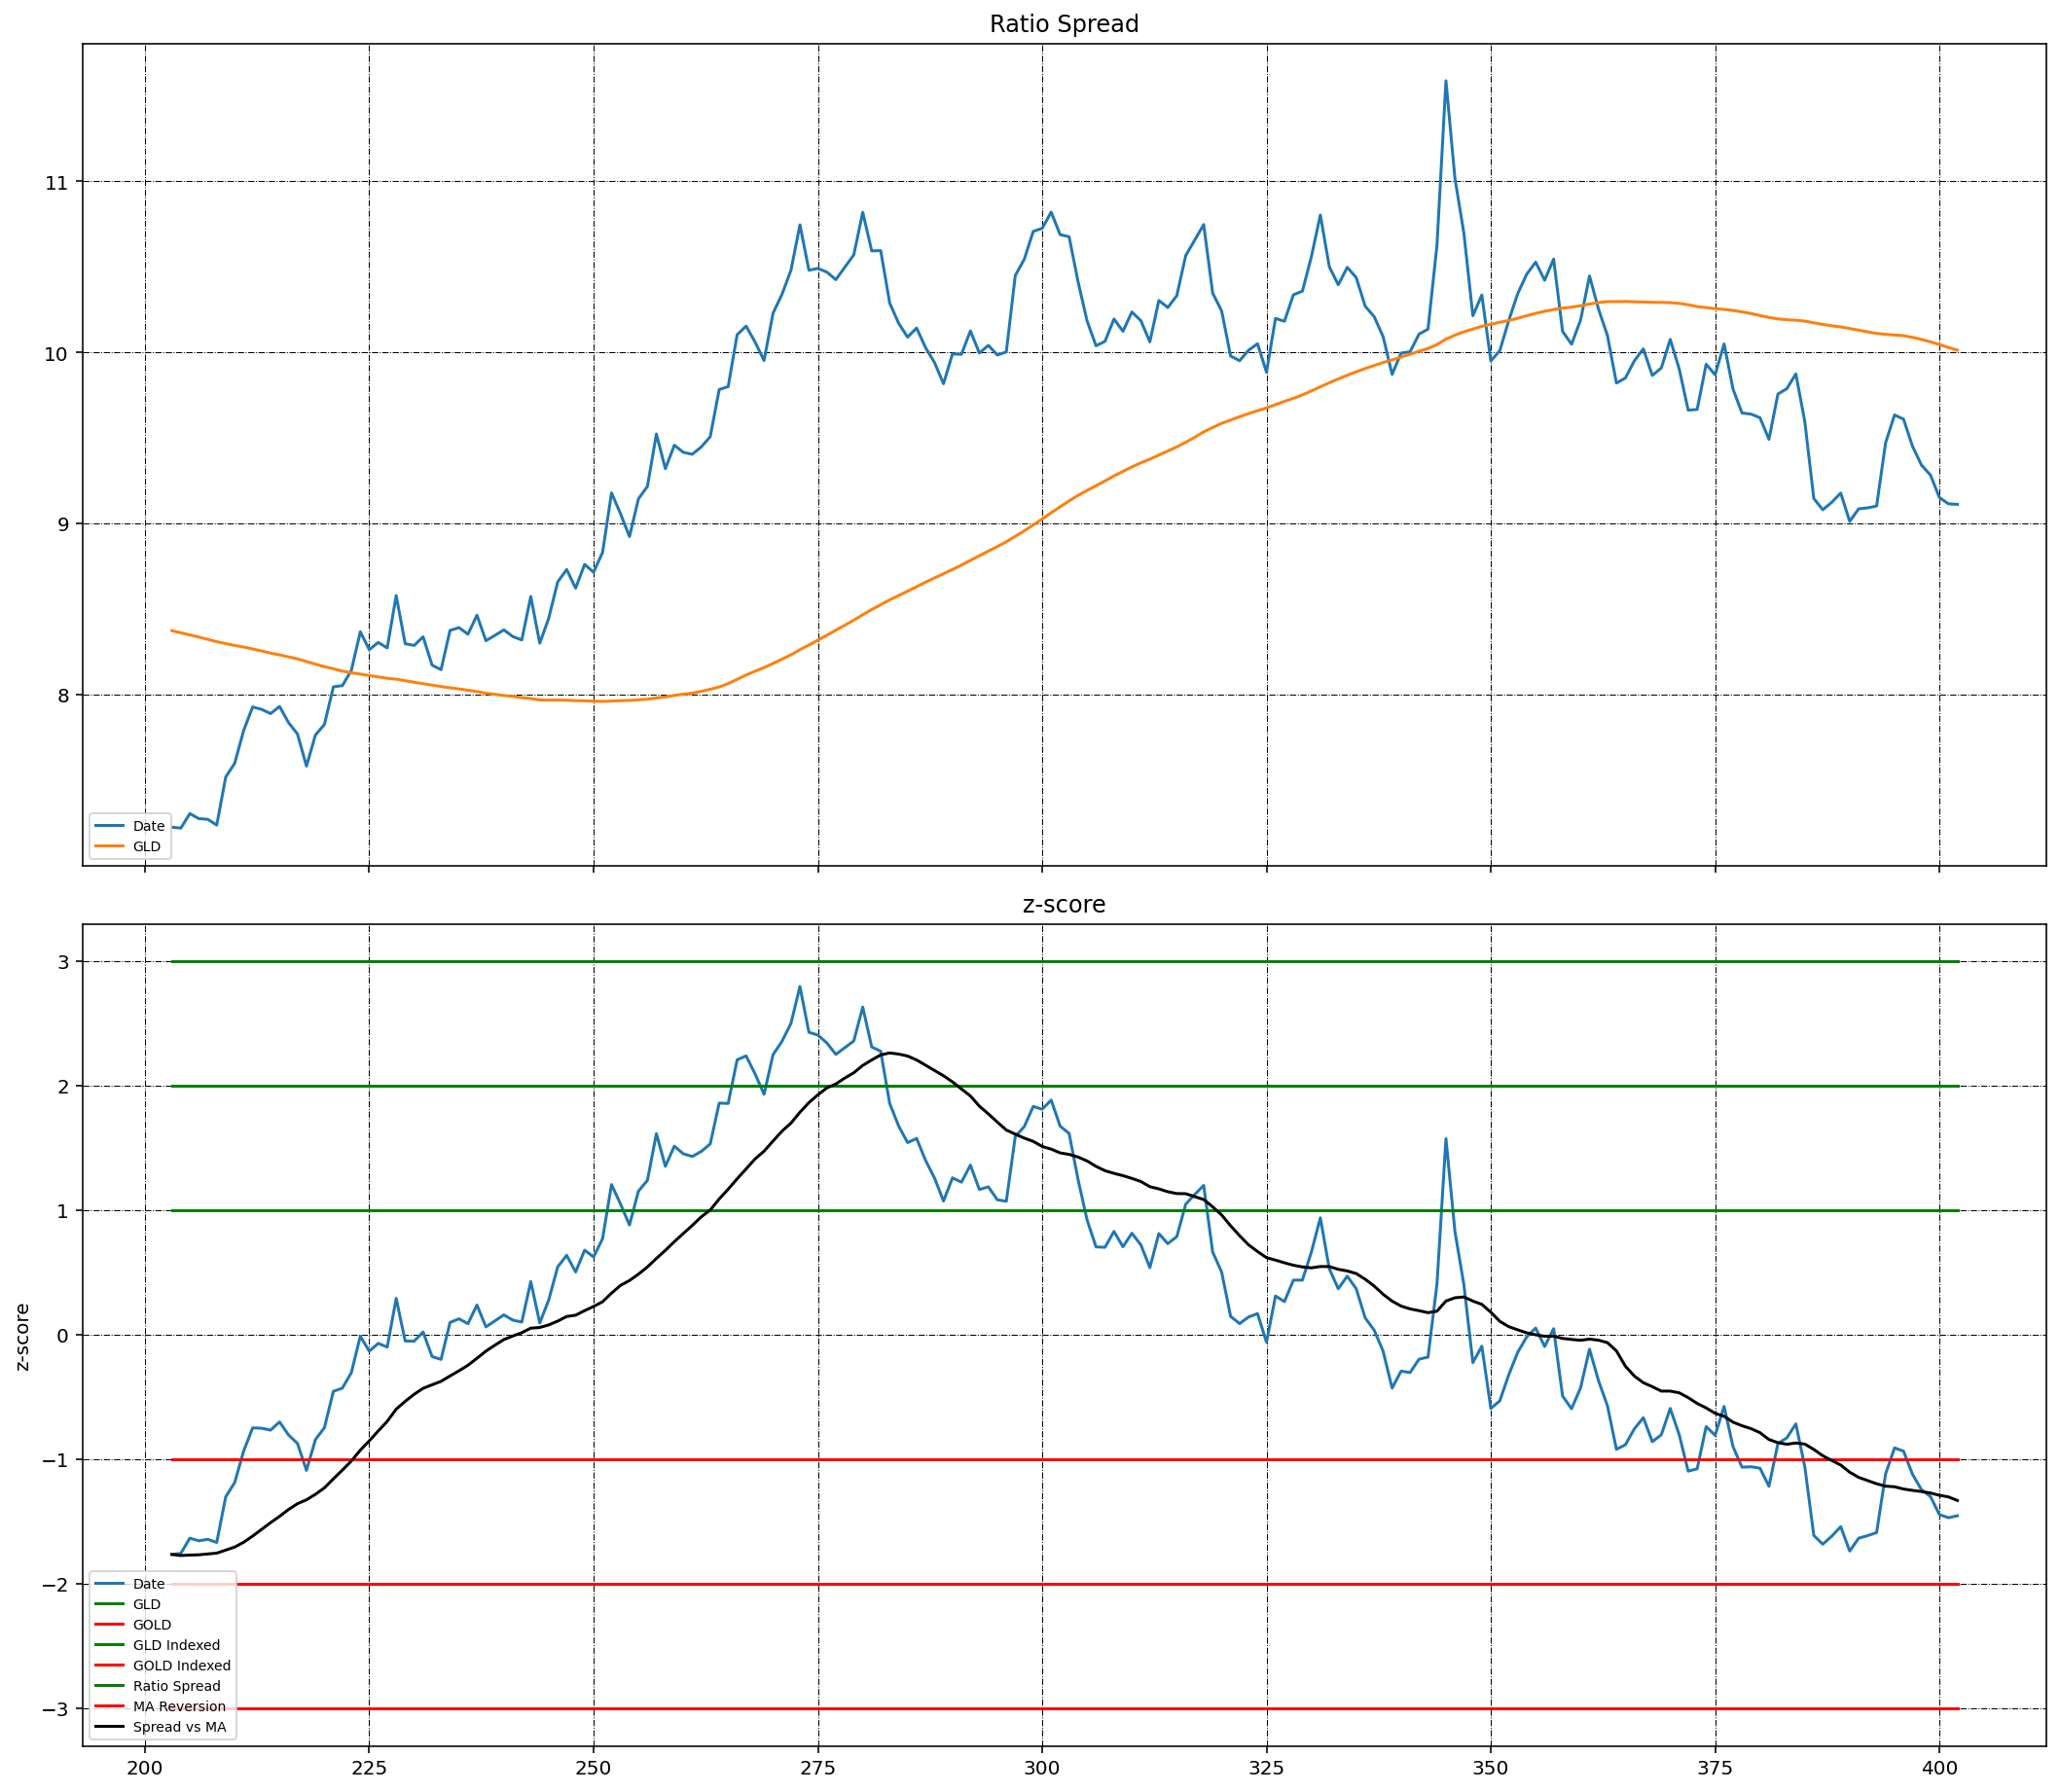

In [92]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(2, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)

# First graph

#Data
axs[0].plot(zoom_data['Ratio Spread'])
axs[0].plot(zoom_data['MA Reversion'])

#Layout
axs[0].set_title('Ratio Spread') # change to spread of the tickers
axs[0].legend(zoom_data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


# Second graph
#Data
axs[1].plot(zoom_data['z-score'])
axs[1].plot(zoom_data['s+1'], label="s1", color="green")
axs[1].plot(zoom_data['s-1'], label="s-1", color="red")
axs[1].plot(zoom_data['s+2'], label="s2", color="green")
axs[1].plot(zoom_data['s-2'], label="s-2", color="red")
axs[1].plot(zoom_data['s+3'], label="s3", color="green")
axs[1].plot(zoom_data['s-3'], label="s-3", color="red")
axs[1].plot(zoom_data['MA Entry'], label="MA Entry", color="black")

#Layout
axs[1].set_title('z-score')
axs[1].legend(zoom_data, loc="lower left", prop={'size': 7}, shadow = False)
axs[1].set_ylabel('z-score')
axs[1].grid(which="major", color='k', linestyle='-.', linewidth=0.5)